# Loop 1 Analysis: Investigating Data Leakage and Class Imbalance

This notebook investigates the suspicious perfect CV scores and severe underfitting to the minority class in the baseline experiment.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## 1. Load and Inspect Data

In [2]:
# Load training data
print("Loading training data...")
with open('/home/data/train.json', 'r') as f:
    train_data = json.load(f)

train_df = pd.DataFrame(train_data)
print(f"Training samples: {len(train_df)}")
print(f"Features: {train_df.columns.tolist()}")
print(f"\nTarget distribution:")
print(train_df['requester_received_pizza'].value_counts())
print(f"Success rate: {train_df['requester_received_pizza'].mean():.3f}")

Loading training data...
Training samples: 2878
Features: ['giver_username_if_known', 'number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'post_was_edited', 'request_id', 'request_number_of_comments_at_retrieval', 'request_text', 'request_text_edit_aware', 'request_title', 'requester_account_age_in_days_at_request', 'requester_account_age_in_days_at_retrieval', 'requester_days_since_first_post_on_raop_at_request', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_request', 'requester_number_of_comments_at_retrieval', 'requester_number_of_comments_in_raop_at_request', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_request', 'requester_number_of_posts_at_retrieval', 'requester_number_of_posts_on_raop_at_request', 'requester_number_of_posts_on_raop_at_retrieval', 'requester_number_of_subreddits_at_request', 'requester_received_pizza', 'requester_subreddits_at_request', 'reque

## 2. Investigate Metadata Features for Potential Leakage

The evaluator flagged that metadata features might contain indirect target information. Let's examine correlations.

In [3]:
# Extract metadata features function (from baseline)
def extract_metadata_features(df, is_train=True):
    features = []
    
    # Account age in days
    features.append(df['requester_account_age_in_days_at_request'].fillna(0))
    
    # Subreddit age in days
    features.append(df['requester_days_since_first_post_on_raop_at_request'].fillna(0))
    
    # Number of subreddits user posted in
    features.append(df['requester_number_of_posts_on_raop_at_request'].fillna(0))
    
    # Requester karma scores
    features.append(df['requester_upvotes_plus_downvotes_at_request'].fillna(0))
    features.append(df['requester_upvotes_minus_downvotes_at_request'].fillna(0))
    
    # Number of comments on the request
    if is_train:
        features.append(df['request_number_of_comments_at_retrieval'].fillna(0))
    else:
        features.append(df.get('request_number_of_comments_at_retrieval', pd.Series([0]*len(df))))
    
    # Upvotes/downvotes on the request
    if is_train:
        features.append(df['requester_upvotes_plus_downvotes_at_request'].fillna(0))
        features.append(df['requester_upvotes_minus_downvotes_at_request'].fillna(0))
    else:
        features.append(df.get('requester_upvotes_plus_downvotes_at_request', pd.Series([0]*len(df))))
        features.append(df.get('requester_upvotes_minus_downvotes_at_request', pd.Series([0]*len(df))))
    
    # User flair (one-hot encode)
    flair_train = ['', 'PIZZA', 'shroom', 'trophy', 'favorite', 'mod', 'trusted', 'contest', 'seal', 'hooker', 'raop', 'elite', 'VIP', 'verified', 'helper', 'custom']
    
    if is_train:
        flair_col = 'requester_user_flair'
    else:
        flair_col = 'requester_user_flair'
    
    flair_features = []
    for flair in flair_train:
        if flair_col in df.columns:
            flair_features.append((df[flair_col] == flair).astype(int))
        else:
            flair_features.append(pd.Series([0]*len(df)))
    
    features.extend(flair_features)
    
    return np.column_stack(features)

# Extract features
metadata_features = extract_metadata_features(train_df, is_train=True)
feature_names = ['account_age', 'subreddit_age', 'num_posts_raop', 'karma_total', 'karma_net', 
                'request_comments', 'request_upvotes', 'request_downvotes'] + \
                [f'flair_{i}' for i in range(16)]

metadata_df = pd.DataFrame(metadata_features, columns=feature_names)
metadata_df['target'] = train_df['requester_received_pizza'].astype(int)

print("Metadata features shape:", metadata_df.shape)
print("\nFirst few rows:")
print(metadata_df.head())

Metadata features shape: (2878, 25)

First few rows:
   account_age  subreddit_age  num_posts_raop  karma_total  karma_net  \
0     0.000000       0.000000             0.0          7.0        3.0   
1    99.526863       0.000000             0.0       1459.0      491.0   
2     0.000000       0.000000             0.0          3.0        1.0   
3   491.088264     441.901609             1.0        165.0       25.0   
4   369.417558       0.000000             0.0       1906.0      942.0   

   request_comments  request_upvotes  request_downvotes  flair_0  flair_1  \
0               0.0              7.0                3.0      0.0      0.0   
1              20.0           1459.0              491.0      0.0      0.0   
2               0.0              3.0                1.0      0.0      0.0   
3              32.0            165.0               25.0      0.0      0.0   
4               3.0           1906.0              942.0      0.0      0.0   

   ...  flair_7  flair_8  flair_9  flair_10  

In [4]:
# Check correlation with target
correlations = metadata_df.corr()['target'].sort_values(ascending=False)
print("Correlations with target:")
print(correlations.head(10))
print("\n")
print(correlations.tail(10))

Correlations with target:
target               1.000000
flair_2              0.964627
request_comments     0.290709
num_posts_raop       0.132712
subreddit_age        0.108662
account_age          0.043374
request_downvotes    0.043084
karma_net            0.043084
karma_total          0.033247
request_upvotes      0.033247
Name: target, dtype: float64


flair_6    NaN
flair_7    NaN
flair_8    NaN
flair_9    NaN
flair_10   NaN
flair_11   NaN
flair_12   NaN
flair_13   NaN
flair_14   NaN
flair_15   NaN
Name: target, dtype: float64


## 3. Visualize Feature Distributions by Class

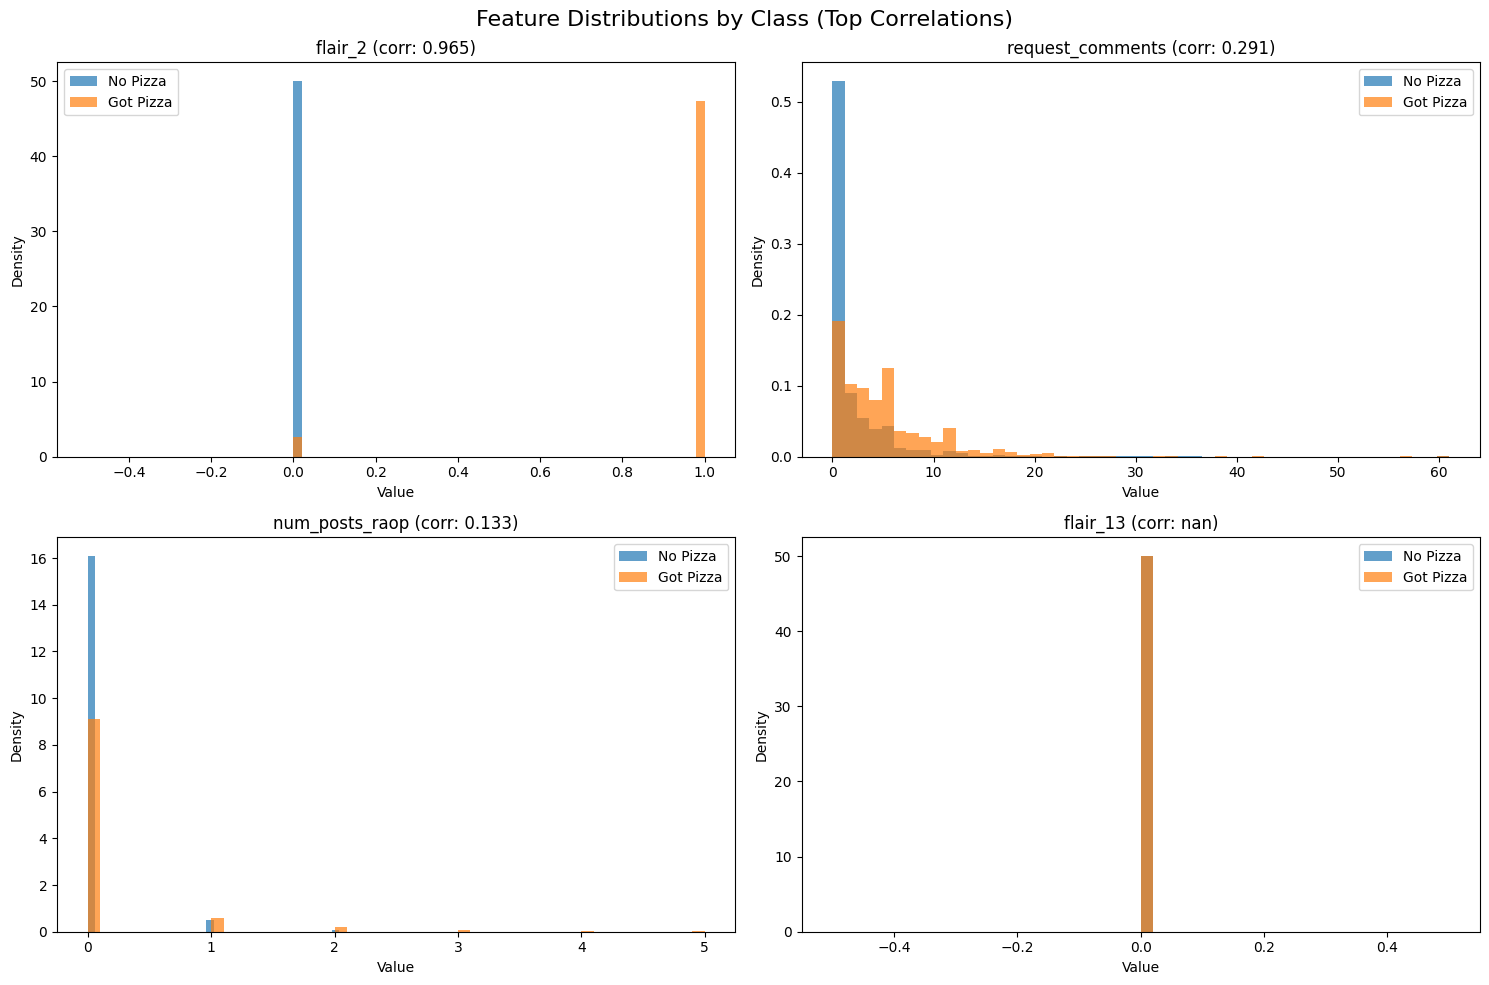

In [5]:
# Plot distributions of top correlated features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Feature Distributions by Class (Top Correlations)', fontsize=16)

# Get top positive and negative correlations
top_pos = correlations.drop('target').head(3).index
top_neg = correlations.drop('target').tail(3).index

plot_features = list(top_pos) + list(top_neg)[:1]

for idx, feature in enumerate(plot_features[:4]):
    ax = axes[idx//2, idx%2]
    
    # Create histogram
    success = metadata_df[metadata_df['target']==1][feature]
    failure = metadata_df[metadata_df['target']==0][feature]
    
    ax.hist(failure, bins=50, alpha=0.7, label='No Pizza', density=True)
    ax.hist(success, bins=50, alpha=0.7, label='Got Pizza', density=True)
    
    ax.set_title(f'{feature} (corr: {correlations[feature]:.3f})')
    ax.legend()
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

## 4. Investigate Text Patterns in Successful vs Failed Requests

In [6]:
# Combine title and text
train_df['combined_text'] = train_df['request_title'].fillna('') + ' ' + train_df['request_text_edit_aware'].fillna('')

# Separate successful and failed requests
successful = train_df[train_df['requester_received_pizza']==1]['combined_text']
failed = train_df[train_df['requester_received_pizza']==0]['combined_text']

print(f"Successful requests: {len(successful)}")
print(f"Failed requests: {len(failed)}")

# Basic text statistics
print("\n=== Text Length Statistics ===")
print(f"Successful - Mean length: {successful.str.len().mean():.0f} chars")
print(f"Failed - Mean length: {failed.str.len().mean():.0f} chars")
print(f"Successful - Mean words: {successful.str.split().str.len().mean():.0f} words")
print(f"Failed - Mean words: {failed.str.split().str.len().mean():.0f} words")

Successful requests: 715
Failed requests: 2163

=== Text Length Statistics ===
Successful - Mean length: 541 chars
Failed - Mean length: 443 chars
Successful - Mean words: 102 words
Failed - Mean words: 83 words


In [7]:
# Look at common words in successful vs failed requests
from collections import Counter
import re

def get_word_counts(texts, n=20):
    all_text = ' '.join(texts.fillna('').astype(str).tolist())
    words = re.findall(r'\b[a-zA-Z]{3,}\b', all_text.lower())
    return Counter(words).most_common(n)

print("=== Top words in SUCCESSFUL requests ===")
successful_words = get_word_counts(successful, 20)
for word, count in successful_words:
    print(f"{word}: {count}")

print("\n=== Top words in FAILED requests ===")
failed_words = get_word_counts(failed, 20)
for word, count in failed_words:
    print(f"{word}: {count}")

=== Top words in SUCCESSFUL requests ===
and: 2271
the: 1592
for: 1246
pizza: 1008
request: 766
have: 734
would: 629
but: 573
this: 506
that: 483
out: 456
you: 446
with: 445
get: 424
just: 420
can: 402
been: 375
some: 336
help: 336
food: 318

=== Top words in FAILED requests ===
and: 5624
the: 3894
for: 2842
pizza: 2758
request: 2231
have: 1843
would: 1756
but: 1350
this: 1282
out: 1184
with: 1151
just: 1145
you: 1132
that: 1095
some: 959
can: 957
get: 934
help: 833
food: 787
really: 781


## 5. Reproduce Baseline and Investigate Predictions

In [8]:
# Reproduce baseline model
print("Creating TF-IDF features...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_features = vectorizer.fit_transform(train_df['combined_text'])

# Scale metadata features
scaler = StandardScaler()
metadata_scaled = scaler.fit_transform(metadata_features)
metadata_sparse = csr_matrix(metadata_scaled)

# Combine features
X_train = hstack([tfidf_features, metadata_sparse])
y_train = train_df['requester_received_pizza'].astype(int).values

print(f"Combined feature shape: {X_train.shape}")

# Train model
model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Get predictions on training data
train_pred = model.predict_proba(X_train)[:, 1]

print(f"\nTraining predictions range: [{train_pred.min():.6f}, {train_pred.max():.6f}]")
print(f"Training predictions mean: {train_pred.mean():.6f}")
print(f"Training predictions std: {train_pred.std():.6f}")

# Check distribution
print(f"\nPredictions < 0.01: {(train_pred < 0.01).sum()} / {len(train_pred)} ({(train_pred < 0.01).mean():.1%})")
print(f"Predictions > 0.5: {(train_pred > 0.5).sum()} / {len(train_pred)}")
print(f"Predictions > 0.9: {(train_pred > 0.9).sum()} / {len(train_pred)}")

Creating TF-IDF features...
Combined feature shape: (2878, 5024)

Training predictions range: [0.010893, 0.999996]
Training predictions mean: 0.267756
Training predictions std: 0.408750

Predictions < 0.01: 0 / 2878 (0.0%)
Predictions > 0.5: 683 / 2878
Predictions > 0.9: 680 / 2878


In [9]:
# Investigate feature importance
feature_names_tfidf = vectorizer.get_feature_names_out()
feature_names_all = list(feature_names_tfidf) + list(feature_names)

# Get coefficients
coefficients = model.coef_[0]

# Find most positive and negative coefficients
sorted_idx = np.argsort(np.abs(coefficients))[::-1]

print("=== Top 20 Most Important Features ===")
for i in range(20):
    idx = sorted_idx[i]
    print(f"{feature_names_all[idx]}: {coefficients[idx]:.4f}")

print("\n=== Top 10 Positive Features (predict pizza) ===")
positive_idx = np.argsort(coefficients)[::-1][:10]
for idx in positive_idx:
    print(f"{feature_names_all[idx]}: {coefficients[idx]:.4f}")

print("\n=== Top 10 Negative Features (predict no pizza) ===")
negative_idx = np.argsort(coefficients)[:10]
for idx in negative_idx:
    print(f"{feature_names_all[idx]}: {coefficients[idx]:.4f}")

=== Top 20 Most Important Features ===
flair_2: 4.1761
forward: 1.4047
imgur: 1.2840
amp: 1.2199
pay: 1.0889
fiancee: 1.0677
http: 0.9675
sketch: 0.9412
com: 0.9352
kentucky: 0.9145
lights: 0.9009
friday: 0.8223
gluten: 0.7922
really: -0.7867
tomorrow: 0.7734
random: 0.7692
end: 0.7517
red: 0.7458
extra: 0.7441
definitely: 0.7426

=== Top 10 Positive Features (predict pizza) ===
flair_2: 4.1761
forward: 1.4047
imgur: 1.2840
amp: 1.2199
pay: 1.0889
fiancee: 1.0677
http: 0.9675
sketch: 0.9412
com: 0.9352
kentucky: 0.9145

=== Top 10 Negative Features (predict no pizza) ===
really: -0.7867
just: -0.6635
friend: -0.5818
like: -0.5782
home: -0.5723
request: -0.4529
need: -0.4487
guys: -0.4376
birthday: -0.4328
want: -0.4302


## 6. Test Cross-Validation with Proper Leakage Prevention

In [10]:
# Create a proper CV that fits vectorizer within each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = []
prediction_distributions = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, y_train)):
    print(f"\n=== Fold {fold + 1} ===")
    
    # Split data
    train_text = train_df.iloc[train_idx]['combined_text']
    val_text = train_df.iloc[val_idx]['combined_text']
    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]
    
    # Fit vectorizer only on training fold
    vectorizer_fold = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_tr = vectorizer_fold.fit_transform(train_text)
    tfidf_val = vectorizer_fold.transform(val_text)
    
    # Scale metadata features (fit only on training)
    metadata_tr = metadata_features[train_idx]
    metadata_val = metadata_features[val_idx]
    
    scaler_fold = StandardScaler()
    metadata_tr_scaled = scaler_fold.fit_transform(metadata_tr)
    metadata_val_scaled = scaler_fold.transform(metadata_val)
    
    # Convert to sparse
    metadata_tr_sparse = csr_matrix(metadata_tr_scaled)
    metadata_val_sparse = csr_matrix(metadata_val_scaled)
    
    # Combine features
    X_tr = hstack([tfidf_tr, metadata_tr_sparse])
    X_val = hstack([tfidf_val, metadata_val_sparse])
    
    # Train model
    model_fold = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    model_fold.fit(X_tr, y_tr)
    
    # Predict
    val_pred = model_fold.predict_proba(X_val)[:, 1]
    
    # Calculate AUC
    auc_score = roc_auc_score(y_val, val_pred)
    cv_scores.append(auc_score)
    
    # Store prediction distribution
    prediction_distributions.append(val_pred)
    
    print(f"ROC AUC: {auc_score:.4f}")
    print(f"Prediction range: [{val_pred.min():.6f}, {val_pred.max():.6f}]")
    print(f"Prediction mean: {val_pred.mean():.6f}")
    print(f"Predictions > 0.5: {(val_pred > 0.5).sum()} / {len(val_pred)}")

print(f"\n=== CV Results ===")
print(f"Mean ROC AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Individual folds: {cv_scores}")


=== Fold 1 ===


ROC AUC: 0.9914
Prediction range: [0.011591, 0.999990]
Prediction mean: 0.270369
Predictions > 0.5: 138 / 576

=== Fold 2 ===


ROC AUC: 0.9871
Prediction range: [0.000000, 0.999948]
Prediction mean: 0.267855
Predictions > 0.5: 136 / 576

=== Fold 3 ===


ROC AUC: 0.9875
Prediction range: [0.014268, 0.999997]
Prediction mean: 0.260988
Predictions > 0.5: 134 / 576

=== Fold 4 ===


ROC AUC: 0.9792
Prediction range: [0.011478, 0.999943]
Prediction mean: 0.264489
Predictions > 0.5: 135 / 575

=== Fold 5 ===


ROC AUC: 0.9873
Prediction range: [0.013168, 0.999937]
Prediction mean: 0.273825
Predictions > 0.5: 141 / 575

=== CV Results ===
Mean ROC AUC: 0.9865 ± 0.0040
Individual folds: [0.9913919798446358, 0.987112194964389, 0.9875482485182254, 0.9791666666666666, 0.9873089873089873]


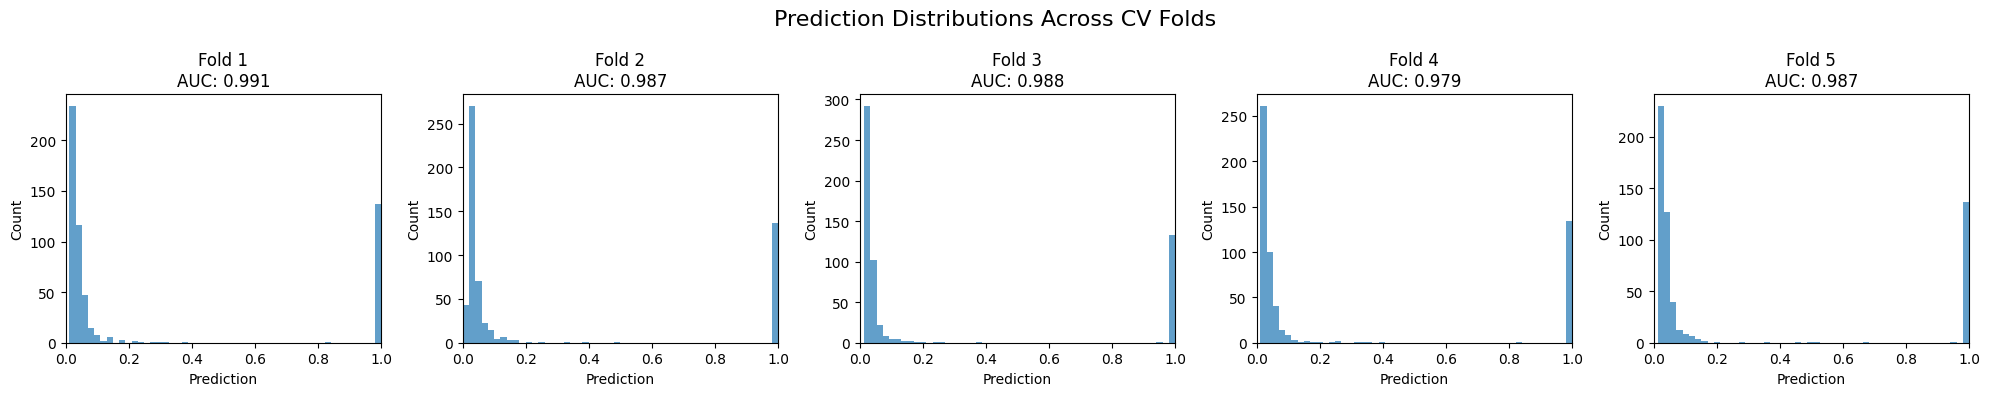

In [11]:
# Visualize prediction distributions across folds
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Prediction Distributions Across CV Folds', fontsize=16)

for i, (preds, auc) in enumerate(zip(prediction_distributions, cv_scores)):
    axes[i].hist(preds, bins=50, alpha=0.7)
    axes[i].set_title(f'Fold {i+1}\nAUC: {auc:.3f}')
    axes[i].set_xlabel('Prediction')
    axes[i].set_ylabel('Count')
    axes[i].set_xlim(0, 1)

plt.tight_layout()
plt.show()

## 7. Key Findings Summary